# Horizontal Lyapunov Orbits
### for L1/L2 using differential corrections

#### tested on Sun-Earth (default), Earth-Moon (default) system

In [1]:
import orbipy as op
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [2]:
# available systems (constant sets for systems)
systems = list(op.crtbp3_model.constants_df.index)
systems

['Sun-Earth (default)',
 'Earth-Moon (default)',
 'Sun-Venus (2026-12-05)',
 'Extreme 0.49']

In [3]:
# USER: select system
system = systems[1]
system

'Earth-Moon (default)'

In [4]:
# USER: select Lagrange point (L1 or L2)
point_name = 'L1'
print('Horizontal Lyapunov family calculation near', point_name, 'in', system, 'system')

Horizontal Lyapunov family calculation near L1 in Earth-Moon (default) system


In [5]:
# USER: set minimum distance to small body in km
# Sun-Earth system: 1000, 1e-12
# Earth-Moon system: 2000, 1e-14

min_dist = 2000
tol = 1e-14

In [6]:
# create model, plotter, scaler
model = op.crtbp3_model(system) #model for calculations
model.integrator.set_params(atol=tol, rtol=tol)
plotter = op.plotter.from_model(model, length_units='Mm', velocity_units='m/s')
scale = plotter.scaler

# model with State Transition Matrix for differential corrections
stmmodel = op.crtbp3_model(system, stm=True)
stmmodel.integrator.set_params(atol=tol, rtol=tol)

pmodel = op.crtbp3_model(system) #model for plotting (with small time step)
pmodel.integrator.set_params(max_step=scale(1, 'd-nd'))
pmodel.integrator.set_params(atol=tol, rtol=tol)

In [7]:
Lpoint = model.__getattribute__(point_name)
RL = model.mu1-Lpoint # distance small body-L1/L2
dx0 = RL/1500 # initial step between orbits by x coordinate
x0 = Lpoint+dx0 # initial spacecraft position at X-axis

In [8]:

# initial step size in kilometers
scale(dx0, 'nd-km')

np.float64(38.686892999250226)

Calculations are made in 2 steps:
1. Calculate 4 initial orbits with initial x coordinates [x0, x0+dx, x0+2\*dx, x0+3\*dx] using border correction method
2. Using cubic interpolation for initial guess of Vy, quadratic interpolation for initial guess of dx, calculate main set of orbits with energy levels j(i)=j(i-1)+dji, where dj(i) = dj(i-1)\*1.001. Differential correction method based on STM are used. X-coordinate interval is: [x0+4\*dx0, mu1-1000 km].

*x0 = L1 + dx, where dx0 = RL1/1000, RL1 = mu1 - L1*

In [9]:
# events for calculation of 4 small orbits using border correction method
left   = op.eventX(Lpoint-10*dx0, accurate=False)
right  = op.eventX(Lpoint+10*dx0, accurate=False)

corr_planes = op.border_correction(model, op.y_direction(), [left], [right])

/home/tka4nik/Workdir/diploma/project/.venv/lib64/python3.12/site-packages/matplotlib/text.py:897: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
/home/tka4nik/Workdir/diploma/project/.venv/lib64/python3.12/site-packages/matplotlib/text.py:898: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))
/home/tka4nik/Workdir/diploma/project/.venv/lib64/python3.12/site-packages/matplotlib/text.py:756: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
/home/tka4nik/Workdir/diploma/project/.venv/lib64/python3.12/site-packages/matplotlib/text.py:757: FutureWarning: Calling float on a single eleme

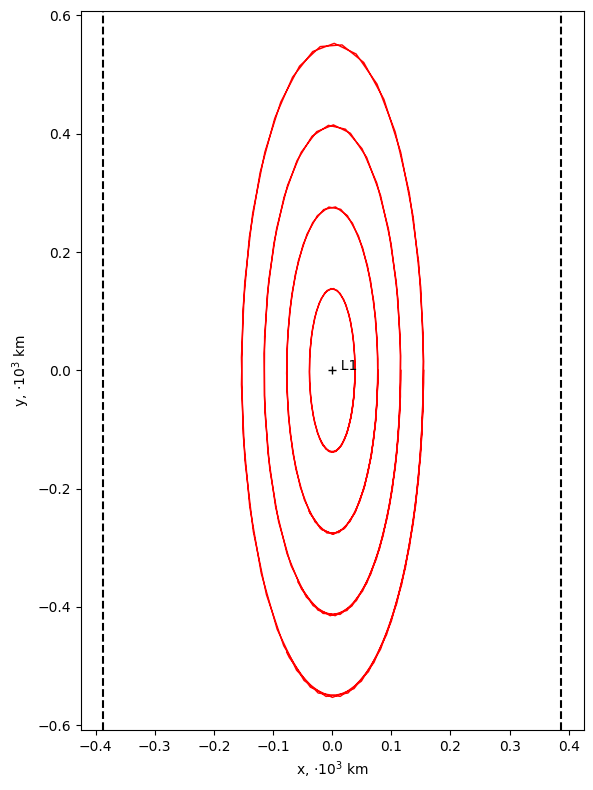

In [10]:
# calculate 4 initial states for small orbits near L1 using border correction method

states = []
# create figure and plot Lagrange point
ax = plotter.plot_proj(plottables=[plotter.__getattribute__(point_name)], fsize=(12,8),
                       projections=('x-y',),centers={'x':Lpoint},
                       colors='k', ls='', marker='+')

# plot left and right events (planes)
plotter.plot_proj(ax=ax, plottables=[left, right], 
                       projections=('x-y',),centers={'x':Lpoint},
                       colors='k', ls='--')

# calculate 4 orbits and plot them
for x in [x0, x0+dx0, x0+2*dx0, x0+3*dx0]:
    s0 = model.get_zero_state()
    s0[0] = x
    corr_planes.mode = 0
    dv = corr_planes.calc_dv(0.0, s0)
    s0 += dv
    states.append(s0.copy())
    df = pmodel.prop(s0, 0., 2*np.pi)
    plotter.plot_proj(df, ax=ax, projections=('x-y',),
                      centers={'x':Lpoint}, colors='rgb', linewidth=1)
    #ax.plot((x-model.L1)*model.R/1000, 0, '.k')
ax.set_aspect('equal')

In [11]:
# initialize differential correction algorithm
dc = op.differential_correction(stmmodel, iterations=100, tol=1e-12)

In [12]:
# initial step size for energy (Jacobi constant)
dj = (model.jacobi(states[-1])-model.jacobi(states[-2]))
dj

np.float64(-4.12906889346587e-06)

In [13]:
# start, end x coordinates
x = states[-1][0]
sgn = (1 if dx0 > 0 else -1)
xend = model.mu1 - sgn*min_dist/model.R
print('x_end:', (xend - Lpoint)*model.R)

x_end: 56030.339498875335


In [14]:
i = 0
while sgn*x < sgn*xend:   
    dx_int = interp1d([model.jacobi(states[j]) for j in range(-4, 0)],
                    [states[j][0] for j in range(-4, 0)], 
                    kind='quadratic',
                    fill_value='extrapolate')
    vint = interp1d([states[j][0] for j in range(-4, 0)],
                    [states[j][4] for j in range(-4, 0)], 
                    kind='cubic',
                    fill_value='extrapolate')
    new_x = dx_int(model.jacobi(states[-1])+dj) # calculate next x coordinate using energy step size dj
    dx = new_x - states[-1][0] # calculate dx step size (only for console output)
    sgn_dx = (1 if dx > 0 else -1)
    if sgn_dx != sgn:
        dx = states[-1][0]-states[-2][0]
    x += dx
    s1 = stmmodel.get_zero_state()
    s1[0] = x
    s1[4] = vint(x) # calculate initial vy guess for current orbit
    try:
        s2, it = dc.find_halo(s1, fixed='x0', ret_it=True, ftol=tol*1e2) # apply differential corrections
    except BaseException as e:
        print('Retry orbit:', '%04d'%i, '%10.2f'%((x-Lpoint)*model.R), '%02d'%it, '%.6f'%(dx*model.R))
        dj *= (1 - 0.1)
        continue
    states.append(s2[:6].copy())
    print('%04d'%i, '%10.2f'%((x-Lpoint)*model.R), '%02d'%it, '%.6f'%(dx*model.R))
    i += 1
    if it < 5:
        dj *= (1 + 0.01) # slightly increase energy step if iteration number is small (by 1%)
    elif it > 10:
        dj *= (1 - 0.01) # slightly decrease step otherwise

0000     181.85 01 27.102921
0001     207.49 01 25.638210
0002     230.98 01 23.487709
0003     252.79 01 21.812860
0004     273.27 01 20.476744
0005     292.63 01 19.359008
0006     311.05 01 18.420086
0007     328.67 01 17.622398
0008     345.60 01 16.937181
0009     361.95 01 16.342630
0010     377.77 01 15.822077
0011     393.13 01 15.362659
0012     408.09 01 14.954333
0013     422.68 01 14.589156
0014     436.94 01 14.260774
0015     450.90 01 13.964044
0016     464.60 01 13.694761
0017     478.04 01 13.449451
0018     491.27 03 13.225218
0019     504.29 00 13.019631
0020     517.12 01 12.830628
0021     529.78 01 12.656454
0022     542.27 01 12.495601
0023     554.62 07 12.346766
0024     566.71 02 12.089309
0025     578.67 01 11.964964
0026     590.52 03 11.849237
0027     602.26 01 11.741488
0028     613.90 04 11.641112
0029     625.45 10 11.547526
0030     636.80 01 11.347798
0031     648.07 03 11.269023
0032     659.26 01 11.195391
0033     670.39 04 11.126601
0034     681.4

/home/tka4nik/Workdir/diploma/project/.venv/lib64/python3.12/site-packages/matplotlib/text.py:897: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
/home/tka4nik/Workdir/diploma/project/.venv/lib64/python3.12/site-packages/matplotlib/text.py:898: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 

/home/tka4nik/Workdir/diploma/project/.venv/lib64/python3.12/site-packages/matplotlib/text.py:756: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
/home/tka4nik/Workdir/diploma/project/.venv/lib64/python3.12/site-packages/matplotlib/text.py:757: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))


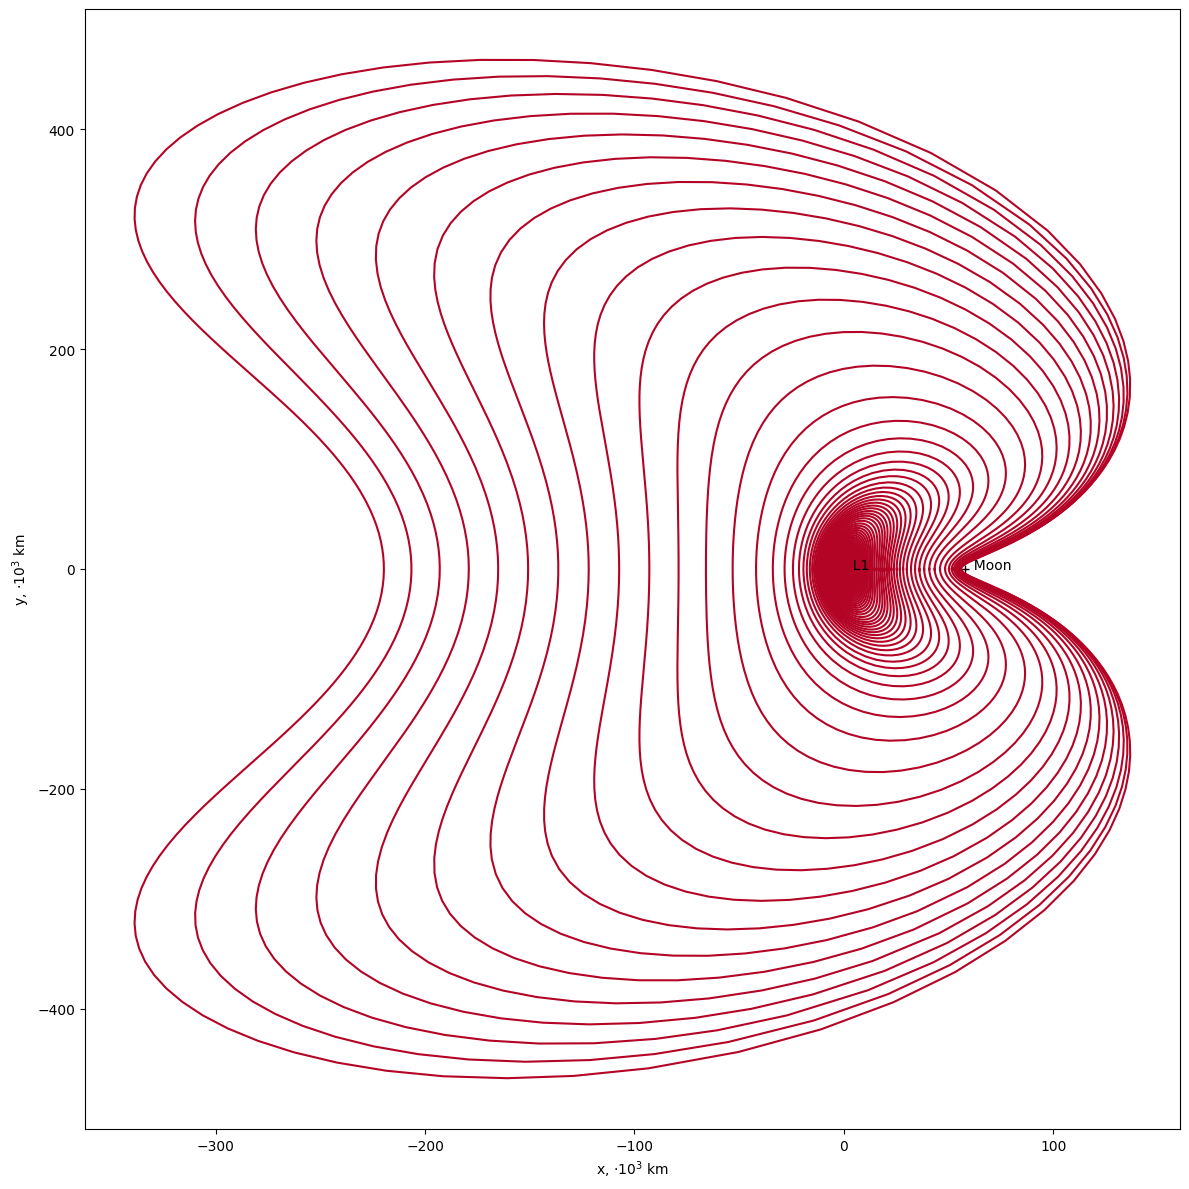

In [15]:
# calculate and plot every 10's orbits for one revolution
evy0   = op.eventY(count=2)
detector = op.event_detector(pmodel, [evy0])

# create figure and plot L1 point
ax = plotter.plot_proj(plottables=[plotter.__getattribute__(point_name), plotter.m], fsize=(12,12),
                       projections=('x-y',),centers={'x':Lpoint},
                       colors='k', ls='', marker='+')
vals = [model.jacobi(states[i]) for i in [-1, 0]]
norm = plt.Normalize(min(vals),max(vals))
for i, s in enumerate(states[::10]):
    dfs, _ = detector.prop(s[:6], 0., 4*np.pi)
    plotter.plot_proj(dfs, ax=ax, projections=('x-y',),centers={'x':Lpoint}, 
                      colors=[plt.cm.coolwarm(norm(model.jacobi(states[i])))])
    print(i, end=' ')

<Axes: xlabel='x, ${\\cdot}10^3$ km', ylabel='vy, m/s'>

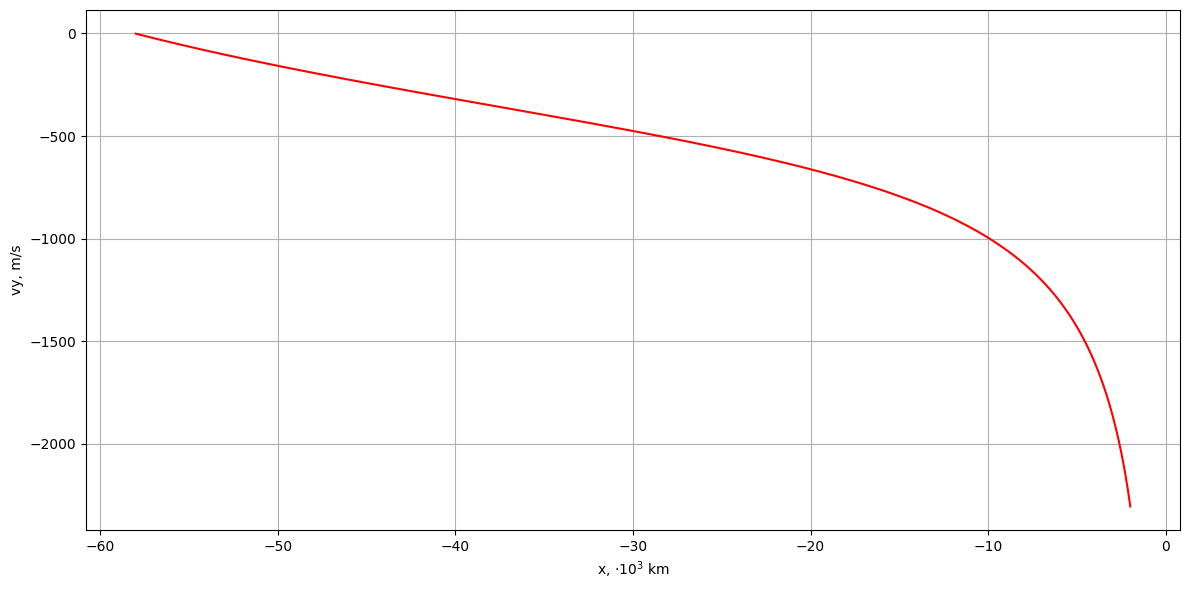

In [16]:
# plot vy(x) graph
arr = np.array(states)
df = pd.DataFrame({'x':arr[:,0], 'vy':arr[:,4]})

plotter.plot_proj(df, fsize=(12, 6), 
                  projections=('x-vy',), 
                  centers={'x':stmmodel.mu1}, 
                  colors='r', grid=True)

In [17]:
# generate file name
fname = 'HLY_' + point_name + '_' + model.const_set + '.csv'
fname

'HLY_L1_Earth-Moon (default).csv'

In [18]:
header = '''Content: Horizontal Lyapunov orbits family
Author: Bober S.A.
Generated by: OrbiPy Tutorial - Horizontal Lyapunov Orbits.ipynb
URL: https://bitbucket.org/stas_bober/orbipy/src/master/tutorials/
Constant set: %s
Lagrange point: %s
Columns: %s'''%(model.const_set, point_name, list(dfs.columns[1:]))
print(header)

Content: Horizontal Lyapunov orbits family
Author: Bober S.A.
Generated by: OrbiPy Tutorial - Horizontal Lyapunov Orbits.ipynb
URL: https://bitbucket.org/stas_bober/orbipy/src/master/tutorials/
Constant set: Earth-Moon (default)
Lagrange point: L1
Columns: ['x', 'y', 'z', 'vx', 'vy', 'vz']


In [19]:
# save results to csv
np.savetxt(fname, arr, header=header)